# Instructions

In today's lab, we will look into image similarity, considering a dataset of film posters which is available on your virtual machine (under <code>/home/student/data</code>, our utililty code already knows of this path and will load the data automagically).

If you would like to examine the posters on your host machine, feel free to download the zip offered to Blackboard.

By using this Jupyter notebook server format, you have the assignments and instructions in one file, and you can dynamically update your code in your browser to play around with various parameters to see the effect.

Throughout the notebook, you will find several <b>Questions</b>. These are meant for you to discuss in your duo while conducting the lab. Note you do <b>not</b> have to submit the answers to these questions to us as part of the final deliverable: they are purely meant for reflection. After the deadline, we will release the answers to them on Blackboard.

As <b>final deliverable</b> to demonstrate your successful completion, please submit a text file through https://www.dropbox.com/request/v7PuvND4meyetyLzwxln named [studentNumberMember1_studentNumberMember2_ranking.txt].

This file should:
* contain a formatted top-10 ranking for a feature-similarity measure configuration you considered to be strong. Please see the 'Final Assignment' instructions at the end of the notebook for the necessary formatting code.
* below the ranking, a short reflection (± 200 words) in which you explain why you thought this ranking was strong, and indicate what visual features you would wish to use or develop if you would like to do film genre classification based on visual poster features.

## Do you have the latest version of the utility code and data?

To ensure you have the latest version of the code, please log into the VM.

You can login through SSH or through the VirtualBox window [login: <code>student</code>, password: <code>3m3mCL4b</code>];
also see the instructions at https://docs.google.com/document/d/1K5Y53Jgc0pPVobLJXP2ynOjRC0eSxmHb37JuxuOdHPs/edit?usp=sharing if you don't know how to do this.

In your terminal window, do the following from your home directory:

<code>$ cd ~/pylib/cs4065 
$ git pull</code>

The <code>poster_images</code> folder with movie posters already is on the VM and configured properly.

<b>In case the repository was not already up to date, please restart the kernel through the top menu (<code>Kernel > Restart</code>) before proceeding</b>.


## Let's get you going!
We will first import all necessary Python modules. Hit 'ctrl-enter' (or the 'run cell button', on the left of the 'stop' icon) to execute the import statements in the cells below.

In [1]:
# Import standard Python modules.
import numpy as np
import os
from pprint import pprint
import sys

# Import extra Python modules.
import cv2
import matplotlib.pyplot as plt
# Make matplotlib plot inline in the notebook
%matplotlib inline 
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

In [2]:
# import utility code from our lab

from datasets import CS4065_Dataset
from cvtools import ipynb_show_color_histogram
from cvtools import ipynb_show_cv2_image
from cvtools import ipynb_show_matrix


In [3]:
# function handle to HSV conversion
_CV2_BGR2HSV = cv2.cv.CV_BGR2HSV

#if you would have used OpenCV 3, the handle should have been set as:
# _CV2_BGR2HSV = cv2.COLOR_BGR2HSV

### 'BGR2HSV', did I read that correctly?
...yes, you did. There are a few not-too-trivial things about OpenCV, one of them being that RGB images are stored in the order Blue-Green-Red rather than Red-Green-Blue.

We did consciously choose for a Python-OpenCV setup though, rather than e.g. Matlab (in which image processing would admittedly be a bit more intuitive), as we feel it would be good for you to get some hands-on experience on open source tools.

In many cases, we will abstract away some gorier OpenCV details by lab utility code in the <code>cvtools</code> module. If you are interested in learning more about this, check out the source code on the VM (<code>/home/student/pylib/cs4065/cvtools.py</code>) or on Github: <code>https://github.com/mmc-tudelft/cs4065/blob/master/cvtools.py</code>.

## Now, let's start!
Let's first load the dataset.

In [4]:
# Load dataset of images.
poster_images = CS4065_Dataset.get_poster_images()

We will now print the length of our poster array, and the path to the first image referred to in the array.

In [5]:
print len(poster_images)  # Number of images.
print poster_images[0]  # Path to the first image.

318
/home/student/data/cs4065/poster_images/X-Men__First_Class.jpg


Now, let's see what this image looks like.

(317, 214, 3)


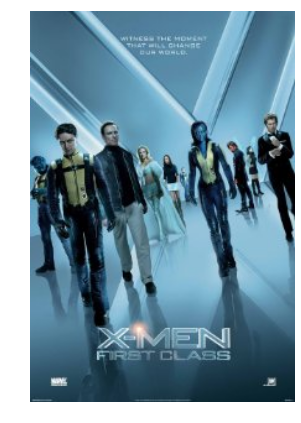

In [6]:
# Load and show an image.
image = cv2.imread(poster_images[0])
ipynb_show_cv2_image(image) # OpenCV is not as trivial with image display, but you can use our utility code for this.
print np.shape(image) # We verify the dimensions of this image.

## Question
What do these three printed numbers indicate?

## Drawing on the image
As you heard in the lecture, an image can be seen as a matrix (or a 2-D signal). Let's modify some of the matrix values to draw rectangles in the poster.

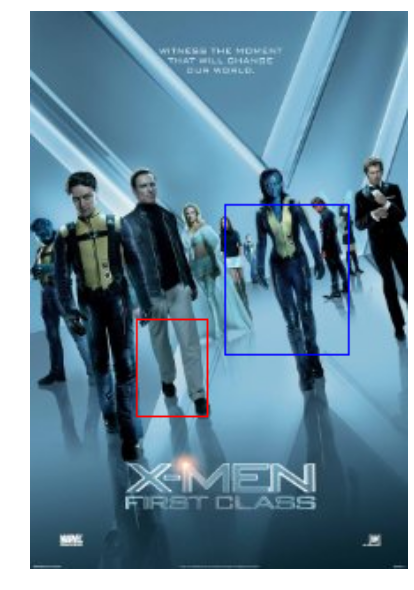

In [22]:
# Let's modify the image a little bit
# (see http://docs.opencv.org/2.4/modules/core/doc/drawing_functions.html).

# We modify a copy of the image.
image_modified = image.copy()

# As mentioned, OpenCV works with the BGR format (by default)
cv2.rectangle(image_modified, (60, 175), (100, 230), (0, 0, 255))
cv2.rectangle(image_modified, (110, 110), (180, 195), (255, 0, 0))

# Use figsize to change the plot dimension
ipynb_show_cv2_image(image_modified, figsize=(10, 10))  

## Question
Modify and rerun the code above to draw differently colored rectangles at different places in the image. What do the second, third and fourth parameter of <code>cv2.rectangle</code> indicate? Does this function use (x, y) or (i, j) indexing?

## Feature extraction
Now, we continue extracting features from the images.

In [60]:
# Extract global histogram features from images.

# Within a notebook, we cannot just enter scripting commands,
# (as we did so far), but we can also define local functions.
# As soon as you execute the cell with a function, it will be in scope
# for the full notebook.

# We now define a general function that extracts histograms.
def compute_histogram(image, channels, bins, ranges):
  # We return the histogram as a single vector, in which the three sub-histograms are concatenated.
  histogram = np.zeros(np.sum(bins))
  
  # We generate a histogram per channel, and then add it to the single-vector histogram.
  for i in range(0, len(channels)):
    channel = channels[i]
    channel_bins = bins[i]
    channel_range = ranges[i]
    channel_histogram = cv2.calcHist(
        [image],
        [channel],
        None, # one could specify an optional mask here (we don't use this here),
        [channel_bins],
        channel_range
        )
    
    # We normalize values in the histogram, such that the values sum up to 1.0.
    channel_histogram_normalized = channel_histogram / np.sum(channel_histogram)
    
    # Now we copy these values to the right indices in our single-vector histogram.
    start_index = int(np.sum(bins[0:channel]))
    end_index = start_index + channel_bins
    histogram[start_index:end_index] = channel_histogram_normalized.flatten()
#     histogram[start_index:end_index] = channel_histogram.flatten()

  return histogram

# Using the compute_histogram function, we can calculate a bgr histogram
def compute_bgr_histogram(image, bins_per_channel):
  channels = [0, 1, 2] # List of channels to analyze.
  ranges = [[0, 256], [0, 256], [0, 256]] # Range per channel.
  return compute_histogram(image, channels, bins_per_channel, ranges)


# Let's add a function for HSV histograms as well.
# Note that 'H' values go from 0 to 180, rather than 0 to 255.
# Recall from the lecture slides that the HSV model has a cilindrical volume,
# rather than a cube. The H (Hue) value would be expressed in degrees over a circle,
# so officially it would run from 0-360. This does not fit into 8 bits though,
# and that is why OpenCV uses 0-180 (by dividing the 'true' H value by 2).
def compute_hsv_histogram(image, bins_per_channel):
  hsv_image = cv2.cvtColor(image, _CV2_BGR2HSV)
  channels = [0, 1, 2] # List of channels to analyze.
  ranges = [[0, 180], [0, 256], [0, 256]] # Range per channel.
  return compute_histogram(hsv_image, channels, bins_per_channel, ranges)


# Question
Now, looking at the code in the cell above, write an own function in the cell below that computes a histogram only using the H and S values of the image.

*When writing your code, consider the amount of bins in your histogram. How many bins were used per channel in the sample functions above? How many bins were used in total for the histogram? Can you write a function using the same overall amount of bins?*

In [196]:
# And another one for HS histograms (as we are not obliged to use all the channels).
def compute_hs_histogram(image, bins_per_channel):
  # YOUR_CODE_GOES_BELOW
  hsv_image = cv2.cvtColor(image, _CV2_BGR2HSV)
#   print np.shape(hsv_image)
  channels = [0, 1] # List of channels to analyze.
  ranges = [[0, 180], [0, 256]] # Range per channel.
  return compute_histogram(hsv_image, channels, bins_per_channel, ranges)
#   pass # replace this 'pass' statement with your code

# Compute histograms.
bgr_histogram = compute_bgr_histogram(image, [8, 8, 8])
print bgr_histogram
print sum(bgr_histogram)
hsv_histogram = compute_hsv_histogram(image, [8,8, 8])
print np.shape(hsv_histogram)

[ 0.09084879  0.11212005  0.0697102   0.08170937  0.12848257  0.17745216
  0.23296678  0.10671011  0.20646246  0.07013768  0.0818273   0.10974675
  0.14133671  0.17226334  0.12871842  0.08950736  0.48782393  0.09743802
  0.09323683  0.08757629  0.06121938  0.04845367  0.0536425   0.07060939]
3.00000001863
(24,)


In [76]:
# Also compute your HS histogram: uncomment and adjust the two lines below.
hs_histogram = compute_hs_histogram(image, [12, 12])
print hs_histogram
print sum(hs_histogram)

[ 0.23110941  0.05317079  0.01410714  0.00784221  0.0047466   0.08772369
  0.04552021  0.38229311  0.11643916  0.01429877  0.0097438   0.0330051
  0.02231788  0.02687284  0.05858074  0.15102156  0.07709543  0.10463163
  0.12865946  0.13244788  0.12456146  0.09177747  0.03834134  0.04369232]
1.99999999953


Let's now plot the histograms.

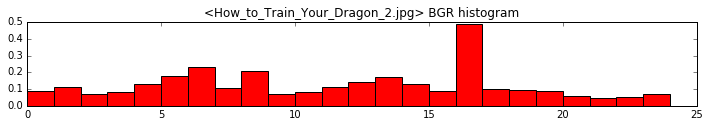

In [206]:
# Show histograms.
_, image_filename = os.path.split(poster_images[99])
ipynb_show_color_histogram(bgr_histogram, '<%s> BGR histogram' % image_filename)


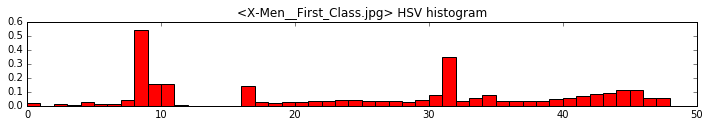

In [190]:
ipynb_show_color_histogram(hsv_histogram, '<%s> HSV histogram' % image_filename)

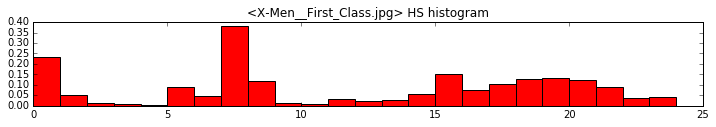

In [79]:
# Also do this for your HS histogram.
ipynb_show_color_histogram(hs_histogram, '<%s> HS histogram' % image_filename)

## Feature computation for the whole dataset
How to these features influence the way in which images are related to one another?

We will compute features for each of our items in the dataset, and then build a (dis)similarity matrix.

In [212]:
# Let's compare all the images by building a feature matrix and a (dis-)similarity one.

# We will try different features.
feature_extractors = {
#     'BGRhist': (compute_bgr_histogram, [8, 8, 8]),  # Pointer to function, bins per channel.
    'HSVhist': (compute_hsv_histogram, [8, 8, 8]),   # Pointer to function, bins per channel.
    # uncomment the line below for your own HS histogram.
#     'HShist': (compute_hs_histogram, [12,12]),
}

# Let's compute the feature matrices.
number_of_images = len(poster_images)
feature_matrices = {}

# We iterate over the various features and compute the feature vectors.
for feature_name in feature_extractors:
  print 'computing %s feature matrix' % feature_name
  (feature_extractor, bins_per_channel) = feature_extractors[feature_name]

  # Initialize matrix.
  feature_matrices[feature_name] = np.zeros(
      (number_of_images, int(np.sum(bins_per_channel))), np.float32)

  # Compute feature vectors.
  for index, image_path in enumerate(poster_images):
    image = cv2.imread(image_path)
    feature_matrices[feature_name][index, :] = feature_extractor(image, bins_per_channel)

  # Show statistics.
  print ' - size', np.shape(feature_matrices[feature_name])
  print ' - min: %.3f' % np.min(feature_matrices[feature_name])
  print ' - max: %.3f' % np.max(feature_matrices[feature_name])
#   print feature_matrices[feature_name]

computing HSVhist feature matrix
 - size (318, 24)
 - min: 0.000
 - max: 1.000


## Computing distances
Now, we are going to compute the distances between the items in our dataset.

computing distance matrix (feature: HSVhist, metric: intersection_area)


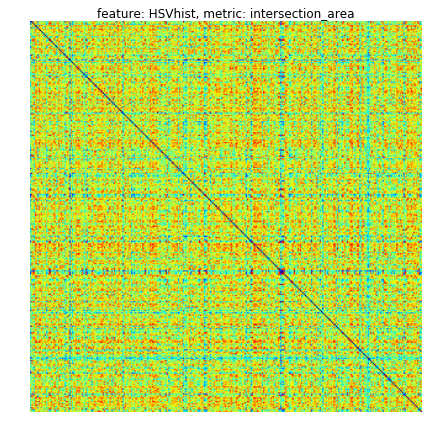

In [213]:
# We will try different feature vector distance metrics.
features_distance_metrics = {
#     'euclidean': 'euclidean',  # Or lambda u, v: np.sqrt(((u-v)**2).sum()) (slower).
    'intersection_area': lambda u, v: np.sum(np.min([u, v], 0)),  # NB: this is a similarity metric.
    # you can expand this list with own implementation of metrics, or references to metrics in scipy
    # (see scipy.distance.pdist reference below)
#     'hamming': 'hamming',
#     'mahalanobis':'mahalanobis',
}

# Let's compute the distance matrices.
distance_matrices = {}
for distance_metric_name in features_distance_metrics:
  distance_matrices[distance_metric_name] = {}
  for feature_name in feature_extractors:
    plot_title = 'feature: %s, metric: %s' % (feature_name, distance_metric_name)
    print 'computing distance matrix (%s)' % plot_title
    
    # Compute the distance matrix using scipy.distance.pdist
    # (see http://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.spatial.distance.pdist.html).
    distance_matrices[distance_metric_name][feature_name] = squareform(pdist(
        feature_matrices[feature_name], features_distance_metrics[distance_metric_name]))
#     print distance_matrices[distance_metric_name][feature_name]
#     print np.shape(distance_matrices[distance_metric_name][feature_name])
    # Check the size.
    assert np.shape(distance_matrices[distance_metric_name][feature_name])[0] == number_of_images

    # Plot.
    ipynb_show_matrix(distance_matrices[distance_metric_name][feature_name], plot_title)
    if distance_metric_name=='hamming':
        print distance_matrices[distance_metric_name][feature_name]

## Question
What do these plotted matrices indicate? To what information do the x- and y-axis correspond? What do red/blue colors indicate? What do points on the main diagonal of the matrix indicate?

Let's now examine values in these distance matrices in more detail. Try different matrix indices.

In [214]:
# print distance_matrices['euclidean']['BGRhist']
# print distance_matrices['euclidean']['BGRhist'][0,4]
print distance_matrices['intersection_area']['BGRhist']
print distance_matrices['intersection_area']['BGRhist'][0,0]
print distance_matrices['intersection_area']['BGRhist'][0,4]

KeyError: 'BGRhist'

## Question
Something is not quite right about the values on the diagonal for the 'intersection_area' metric. This has to do with a default value that <code>pdist</code> uses for items on the main diagonal of its output matrix. What is this default value, and what should the value actually be?

We now will fix these diagonal values to the appropriate value.

In [215]:
def calculateShit(x_list):
    result=0
    result=sum(x_list)
    return result



for feature_name in distance_matrices['intersection_area'].keys():
    distance_matrix = distance_matrices['intersection_area'][feature_name]
    collection_size = np.shape(distance_matrix)[0] # square matrix, so it does not matter whether we consider row or column count
#     print collection_size
    for i in range(0, collection_size):
        # Uncomment line below and add the right value
#         print distance_matrix
#         print feature_matrices[feature_name][i]
        distance_matrix[i, i] = calculateShit(feature_matrices[feature_name][i])
#         print distance_matrix[i, i]
        

Let's visually check the matrix plots again.

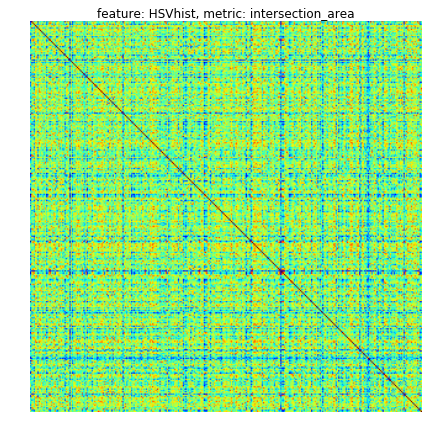

In [216]:
for distance_metric_name in features_distance_metrics:
  for feature_name in feature_extractors:
    plot_title = 'feature: %s, metric: %s' % (feature_name, distance_metric_name)
    ipynb_show_matrix(distance_matrices[distance_metric_name][feature_name], plot_title)

Based on this information, we can find the farthest and nearest items for a given image.

selected image: <X-Men__First_Class.jpg>
 - feature: HSVhist, metric: intersection_area
  top #0: </home/student/data/cs4065/poster_images/Unbroken.jpg>
  top #1: </home/student/data/cs4065/poster_images/American_Gangster.jpg>
  top #2: </home/student/data/cs4065/poster_images/Rocky_Balboa.jpg>
  top #3: </home/student/data/cs4065/poster_images/Yves_Saint_Laurent.jpg>
  top #4: </home/student/data/cs4065/poster_images/Mommie_Dearest.jpg>
  top #5: </home/student/data/cs4065/poster_images/Selma.jpg>
  top #6: </home/student/data/cs4065/poster_images/Warrior.jpg>
  top #7: </home/student/data/cs4065/poster_images/Blow_Out.jpg>
  top #8: </home/student/data/cs4065/poster_images/There_Will_Be_Blood.jpg>
  top #9: </home/student/data/cs4065/poster_images/Rise_of_the_Planet_of_the_Apes.jpg>
  bottom #0: </home/student/data/cs4065/poster_images/X-Men__First_Class.jpg>
  bottom #1: </home/student/data/cs4065/poster_images/The_Reluctant_Dragon.jpg>
  bottom #2: </home/student/data/cs4065/poster

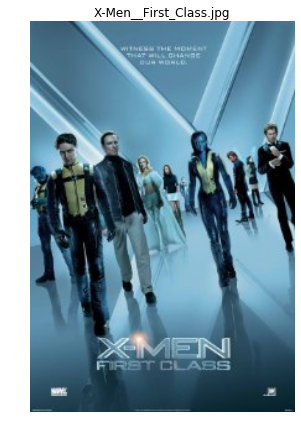

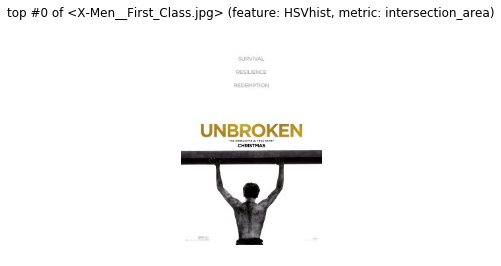

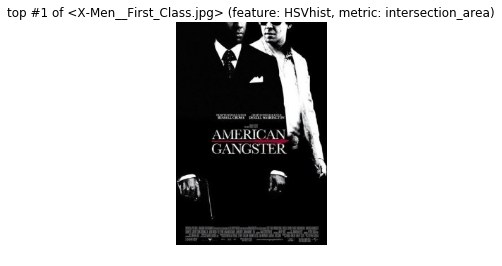

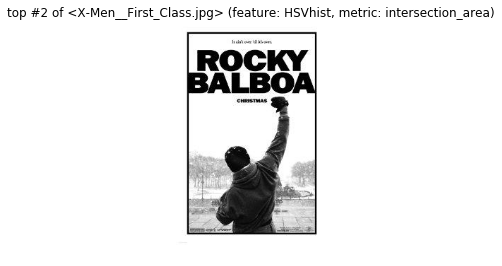

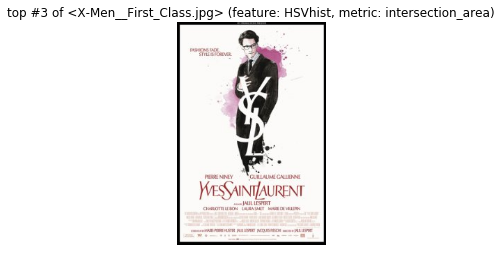

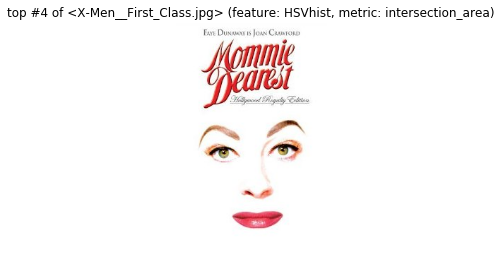

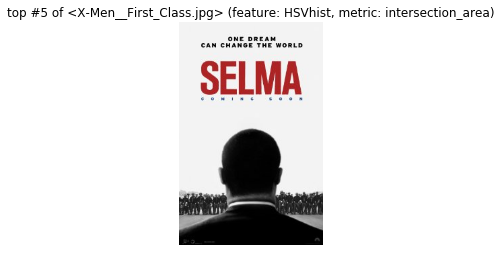

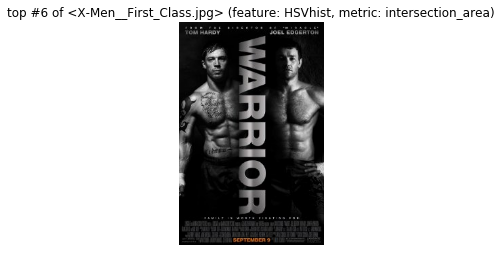

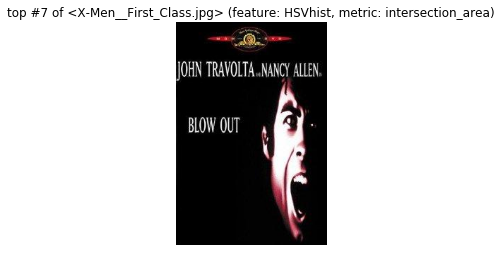

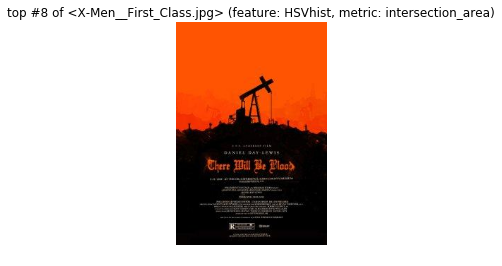

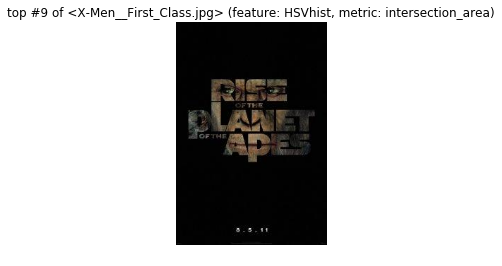

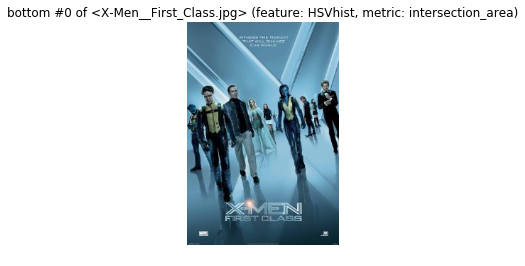

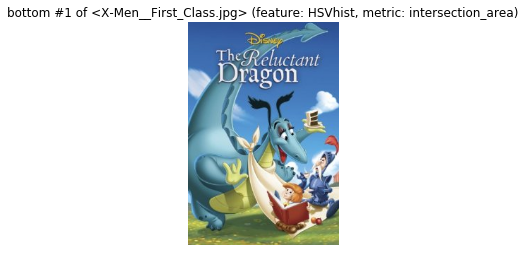

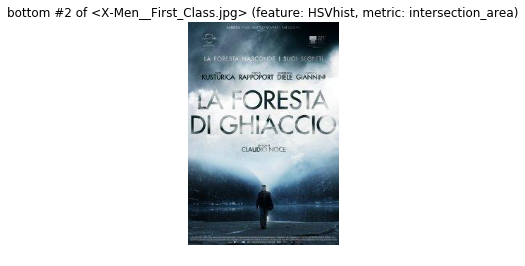

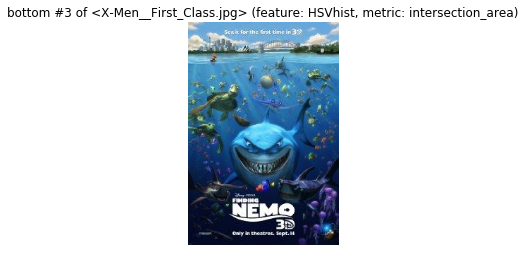

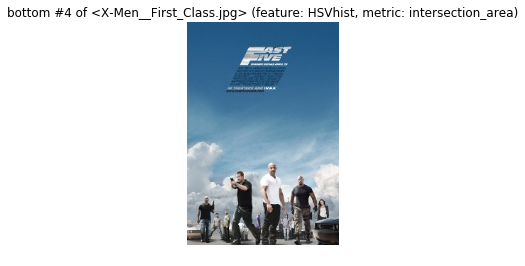

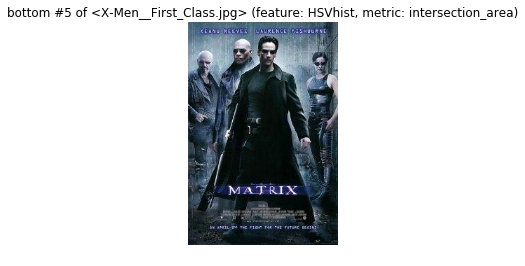

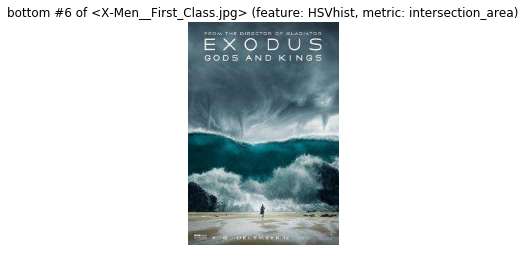

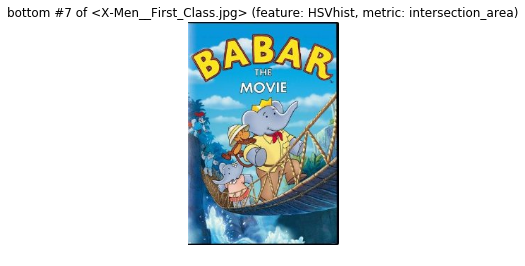

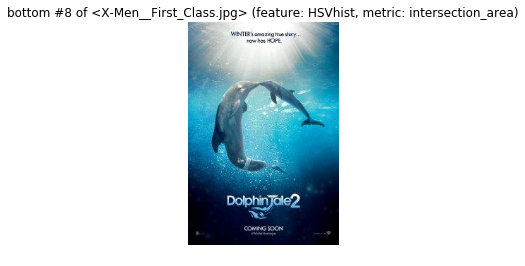

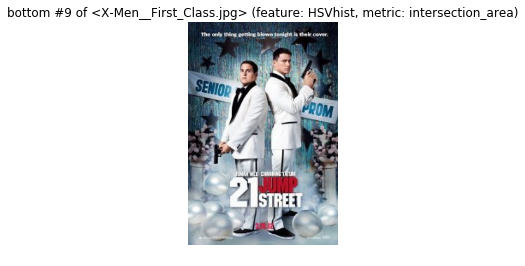

In [217]:
# Let's use the distance matrices to find the farthest/nearest items for a number of random images.
number_of_random_images = 1      # feel free to adjust this parameter
number_of_examples_per_image = 10    # feel free to adjust this parameter

# Choose random images.
random_image_indexes = np.random.randint(0, number_of_images, number_of_random_images)
random_image_indexes = [0]
# Show nearest/farthest items.
for random_image_index in random_image_indexes:
  _, reference_image_name = os.path.split(poster_images[random_image_index])
  print 'selected image: <%s>' % reference_image_name
  reference_image = cv2.imread(poster_images[random_image_index])
  ipynb_show_cv2_image(reference_image, reference_image_name)
  for distance_metric_name in features_distance_metrics:
    for feature_name in feature_extractors:
      plot_base_title = 'feature: %s, metric: %s' % (feature_name, distance_metric_name)
      print ' - %s' % plot_base_title

      # Extract the pairwise scores for the current image.
      pairwise_scores = distance_matrices[distance_metric_name][feature_name][random_image_index, :]

      # Get the indexes sorted by score.
      pairwise_scores_sorted_indexes = np.argsort(pairwise_scores)

      # Find the top k and the bottom k images.
      top_k_indexes = pairwise_scores_sorted_indexes[:number_of_examples_per_image]
      bottom_k_indexes = reversed(pairwise_scores_sorted_indexes[-number_of_examples_per_image:])

      # Show top k images.
      for i, image_index in enumerate(top_k_indexes):
        print '  top #%d: <%s>' % (i, poster_images[image_index])
        image = cv2.imread(poster_images[image_index])
        ipynb_show_cv2_image(image, 'top #%d of <%s> (%s)' % (
            i, reference_image_name, plot_base_title), figsize=(4, 4))
        
      # Show bottom k images.
      for i, image_index in enumerate(bottom_k_indexes):
        print '  bottom #%d: <%s>' % (i, poster_images[image_index])
        image = cv2.imread(poster_images[image_index])
        ipynb_show_cv2_image(image, 'bottom #%d of <%s> (%s)' % (
            i, reference_image_name, plot_base_title), figsize=(4, 4))


## Question
Can you explain why results end up in the top or bottom of the list? What are the main differences in the rankings for the different features and metrics?

## Final Assignment
Please play around with the number of bins and channels you can use in the histograms, and a few more distance metrics (see the pdist documentation, or build your own metric).

This mostly would require you to tweak parts of the code above.

Find a configuration (feature, histogram channels, histogram bin size, (dis)similarity metric) that gives a good ranking for the reference image specified below.

Generate a ranked list for this configuration, such that items at a lower rank index are considered better matches (so the item at location 0 should be better than the item at location 100).

Then, as soon as you have a configuration ranking you like, run the code below to generate a formatted overview of your top-10 results.
Copy the console output into a text file and save the file as [studentNumberMember1_studentNumberMember2_ranking.txt].

Underneath the top-10, add a short reflection to the same text file (± 200 words) in which you explain why you thought this ranking was strong, and indicate what visual features you would wish to use or develop if you would like to do film genre classification based on visual poster features.

Upload the final text file to the Dropbox link given on top of the page.

In [ ]:
# reference image for which you will generate a top-10
final_reference_image_index = 0
final_reference_image = cv2.imread(poster_images[final_reference_image_index])
print pairwise_scores_sorted_indexes

In [ ]:
# Add the code to generate your ranked results for the best configuration you could find here.
# The results should be in a similar form as 'pairwise_scores_sorted_indexes'
# which was generated two code cells above.
# Order your results such that the first items in the list are the best matches.

# YOUR_CODE_FOR_THE_BEST_CONFIGURATION_TO_BE_ADDED_HERE
print type(pairwise_scores_sorted_indexes)
final_scores_sorted_indexes = pairwise_scores_sorted_indexes[::-1]
print final_scores_sorted_indexes

In [ ]:
# generate a formatted list of top-10 ranked results.
# replace the placeholder texts below with your name and a one-line explanation of your approach.
print 'names: %s' % 'Yikai Lan, Zhaoyang Cheng'
print 'feature: %s' % 'HSV'
print 'channels and bins: %s' % 'We used HSV channels and 8 bins for each channel.'
print 'metric: %s\n' % 'intersection_area'

print '*** Top-10 for film %s ***' % poster_images[final_reference_image_index]
# now print the top-10.
top_10_indexes = final_scores_sorted_indexes[:10]
for i, image_index in enumerate(top_10_indexes):
    print '%d.\t%s' % (i, poster_images[image_index])